In [1]:
#import libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import sklearn
import sys

In [3]:
data_dir = '/Users/jyontika/Desktop/Python/github_hughes/opioid-overdose-models/jyontika-MA-data/data'

annual_path = os.path.join(data_dir, 'clean_annual_tract')
quarter_path = os.path.join(data_dir, 'clean_quarter_tract')
semi_path = os.path.join(data_dir, 'clean_semi_tract')

gdf_annual = gpd.read_file(annual_path)
gdf_quarter = gpd.read_file(quarter_path)
gdf_semi = gpd.read_file(semi_path)


In [5]:
gdf_annual['geometry']

0        POLYGON ((-70.25001 42.06410, -70.24959 42.065...
1        POLYGON ((-70.25001 42.06410, -70.24959 42.065...
2        POLYGON ((-70.25001 42.06410, -70.24959 42.065...
3        POLYGON ((-70.25001 42.06410, -70.24959 42.065...
4        POLYGON ((-70.25001 42.06410, -70.24959 42.065...
                               ...                        
35635    POLYGON ((-71.63921 42.53096, -71.63906 42.531...
35636    POLYGON ((-71.63921 42.53096, -71.63906 42.531...
35637    POLYGON ((-71.63921 42.53096, -71.63906 42.531...
35638    POLYGON ((-71.63921 42.53096, -71.63906 42.531...
35639    POLYGON ((-71.63921 42.53096, -71.63906 42.531...
Name: geometry, Length: 35640, dtype: geometry

In [3]:
gdf_annual.shape

(35640, 35)

### Sparsity Rate Tables

In [29]:
annual_deaths = gdf_annual.groupby('year')['deaths'].sum().reset_index()

# Calculate sparsity rate
zero_deaths_count = gdf_annual[gdf_annual['deaths'] == 0].groupby('year').size().reset_index(name='Zero Deaths Count')
total_tracts_count = gdf_annual.groupby('year').size().reset_index(name='Total Tracts Count')
sparsity_df_annual = pd.merge(zero_deaths_count, total_tracts_count, on='year')
sparsity_df_annual['Sparsity Rate'] = (sparsity_df_annual['Zero Deaths Count'] / sparsity_df_annual['Total Tracts Count']) * 100
sparsity_df_annual['Sparsity Rate'] = sparsity_df_annual['Sparsity Rate'].round(3).astype(str) + '%'

# Merge sparsity rate with annual_deaths table
annual_deaths = pd.merge(annual_deaths, sparsity_df_annual[['year', 'Sparsity Rate']], on='year')

# Rename the 'deaths' column
annual_deaths.rename(columns={'deaths': 'Total Deaths'}, inplace=True)

# Exclude 2023 from the table
annual_deaths = annual_deaths[annual_deaths['year'] != 2023]

# Print the resulting table
print(annual_deaths)


    year  Total Deaths Sparsity Rate
0   2000         355.0       81.173%
1   2001         445.0       77.531%
2   2002         476.0       76.605%
3   2003         596.0       71.975%
4   2004         469.0       76.358%
5   2005         547.0       74.259%
6   2006         613.0       70.247%
7   2007         599.0       71.358%
8   2008         597.0       70.988%
9   2009         595.0       71.975%
10  2010         524.0       73.951%
11  2011         621.0       70.123%
12  2012         703.0       67.346%
13  2013         897.0       61.667%
14  2014        1247.0       52.346%
15  2015        1575.0       46.605%
16  2016        1896.0       39.383%
17  2017        1711.0       42.963%
18  2018        1895.0       40.432%
19  2019        1862.0       40.185%
20  2020        1953.0       39.815%
21  2021        2064.0       39.383%


In [38]:
gdf_semi['semiannual'] = pd.NA

# Update 'semiannual' column based on 'season' values
gdf_semi.loc[gdf_semi['season'] == 'jan-jun', 'semiannual'] = 1
gdf_semi.loc[gdf_semi['season'] == 'jul-dec', 'semiannual'] = 2


In [39]:
#semi-annual
semiannual_deaths = gdf_semi.groupby(['year', 'semiannual'])['deaths'].sum().reset_index()

# Calculate sparsity rate
zero_deaths_count = gdf_semi[gdf_semi['deaths'] == 0].groupby(['year', 'semiannual']).size().reset_index(name='Zero Deaths Count')
total_tracts_count = gdf_semi.groupby(['year', 'semiannual']).size().reset_index(name='Total Tracts Count')
sparsity_df_semi = pd.merge(zero_deaths_count, total_tracts_count, on=['year', 'semiannual'])
sparsity_df_semi['Sparsity Rate'] = (sparsity_df_semi['Zero Deaths Count'] / sparsity_df_semi['Total Tracts Count']) * 100
sparsity_df_semi['Sparsity Rate'] = sparsity_df_semi['Sparsity Rate'].round(3).astype(str) + '%'

# Merge sparsity rate with semiannual_deaths table
semiannual_deaths = pd.merge(semiannual_deaths, sparsity_df_semi[['year', 'semiannual', 'Sparsity Rate']], on=['year', 'semiannual'])

semiannual_deaths.rename(columns={'deaths': 'Total Deaths'}, inplace=True)

#format
formatted_table = ''
current_year = None
for _, row in semiannual_deaths.iterrows():
    year = row['year']
    semiannual = row['semiannual']
    total_deaths = row['Total Deaths']
    sparsity_rate = row['Sparsity Rate']
    
    if year != current_year:
        formatted_table += '\n'  # Add an extra space between years
        current_year = year
    
    formatted_table += f"Year: {year}, Semiannual: {semiannual}, Total Deaths: {total_deaths}, Sparsity Rate: {sparsity_rate}\n"

# Print the resulting table
print(formatted_table)





Year: 2000, Semiannual: 1, Total Deaths: 172.0, Sparsity Rate: 90.062%
Year: 2000, Semiannual: 2, Total Deaths: 183.0, Sparsity Rate: 89.63%

Year: 2001, Semiannual: 1, Total Deaths: 224.0, Sparsity Rate: 87.654%
Year: 2001, Semiannual: 2, Total Deaths: 221.0, Sparsity Rate: 88.086%

Year: 2002, Semiannual: 1, Total Deaths: 245.0, Sparsity Rate: 86.605%
Year: 2002, Semiannual: 2, Total Deaths: 231.0, Sparsity Rate: 87.469%

Year: 2003, Semiannual: 1, Total Deaths: 314.0, Sparsity Rate: 83.333%
Year: 2003, Semiannual: 2, Total Deaths: 282.0, Sparsity Rate: 84.63%

Year: 2004, Semiannual: 1, Total Deaths: 218.0, Sparsity Rate: 87.84%
Year: 2004, Semiannual: 2, Total Deaths: 251.0, Sparsity Rate: 86.173%

Year: 2005, Semiannual: 1, Total Deaths: 273.0, Sparsity Rate: 85.494%
Year: 2005, Semiannual: 2, Total Deaths: 274.0, Sparsity Rate: 85.741%

Year: 2006, Semiannual: 1, Total Deaths: 288.0, Sparsity Rate: 84.444%
Year: 2006, Semiannual: 2, Total Deaths: 325.0, Sparsity Rate: 82.778%

Y

### Number Tracts with 5+ Deaths

In [30]:
#number of census tracts with 5+ deaths in a year
result = gdf_annual.groupby('year').apply(lambda x: (x['deaths'] >= 5).sum()).reset_index()

result.columns = ['Year', '   # of Tracts']
print("Number of Census Tracts with\n  5+ Deaths in Given Year\n")
print(result)


Number of Census Tracts with
  5+ Deaths in Given Year

    Year     # of Tracts
0   2000               0
1   2001               1
2   2002               0
3   2003               0
4   2004               1
5   2005               3
6   2006               0
7   2007               0
8   2008               0
9   2009               0
10  2010               3
11  2011               3
12  2012               3
13  2013               4
14  2014              15
15  2015              31
16  2016              44
17  2017              38
18  2018              51
19  2019              40
20  2020              59
21  2021              66


In [47]:
#semiannual 5+ tracts 
result = gdf_semi.groupby(['year', 'semiannual']).apply(lambda x: (x['deaths'] >= 5).sum()).reset_index()
result.columns = ['Year', 'Semiannual Period', '# of Tracts']
print("Number of Census Tracts with 5+ Deaths in Given Semiannual Period\n")
print(result)


Number of Census Tracts with 5+ Deaths in Given Semiannual Period

    Year  Semiannual Period  # of Tracts
0   2000                  1            0
1   2000                  2            0
2   2001                  1            0
3   2001                  2            0
4   2002                  1            0
5   2002                  2            0
6   2003                  1            0
7   2003                  2            0
8   2004                  1            0
9   2004                  2            1
10  2005                  1            0
11  2005                  2            1
12  2006                  1            0
13  2006                  2            0
14  2007                  1            0
15  2007                  2            0
16  2008                  1            0
17  2008                  2            0
18  2009                  1            0
19  2009                  2            0
20  2010                  1            1
21  2010                  2    

### Summary Stats Anual

In [7]:
#calculate mean from 2014-2021?
filtered_df = gdf_annual[(gdf_annual['year'] >= 2014) & (gdf_annual['year'] <= 2021)]
mean_deaths = filtered_df['deaths'].mean()
median_deaths = filtered_df['deaths'].median()

print(mean_deaths)
print(median_deaths)


1.0959104938271604
1.0


In [32]:
# percentiles
percentile_25 = np.percentile(filtered_df['deaths'], 25)
percentile_75 = np.percentile(filtered_df['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 2.0


In [9]:
#min and max
max_deaths = filtered_df['deaths'].max()
min_deaths = filtered_df['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 10.0
Minimum Number of Deaths: 0.0


### Summary Stats Semi Annual

In [48]:
#summary stats semi-annual
#mean and median
gdf_semi_filtered = gdf_semi[gdf_semi['year'].between(2014, 2021)]
mean_deaths = gdf_semi_filtered['deaths'].mean()
median_deaths = gdf_semi_filtered['deaths'].median()

print(mean_deaths)
print(median_deaths)

0.5479552469135802
0.0


In [49]:
# percentiles semiannual
percentile_25 = np.percentile(gdf_semi_filtered['deaths'], 25)
percentile_75 = np.percentile(gdf_semi_filtered['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 1.0


In [50]:
#maximum and min semi-annual
max_deaths = gdf_semi_filtered['deaths'].max()
min_deaths = gdf_semi_filtered['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 9.0
Minimum Number of Deaths: 0.0


### Summary Stats Quarterly

In [55]:
#summary stats QUARTERLY
#mean and median
gdf_quarter_filtered = gdf_quarter[gdf_quarter['year'].between(2014, 2021)]
mean_deaths = gdf_quarter_filtered['deaths'].mean()
median_deaths = gdf_quarter_filtered['deaths'].median()

print(mean_deaths)
print(median_deaths)

0.2739776234567901
0.0


In [56]:
# percentiles quarterly
percentile_25 = np.percentile(gdf_quarter_filtered['deaths'], 25)
percentile_75 = np.percentile(gdf_quarter_filtered['deaths'], 75)

print("25th Percentile:", percentile_25)
print("75th Percentile:", percentile_75)

25th Percentile: 0.0
75th Percentile: 0.0


In [57]:
#maximum and min quarterly
max_deaths = gdf_quarter_filtered['deaths'].max()
min_deaths = gdf_quarter_filtered['deaths'].min()

print("Maximum Number of Deaths:", max_deaths)
print("Minimum Number of Deaths:", min_deaths)

Maximum Number of Deaths: 9.0
Minimum Number of Deaths: 0.0


<Axes: >

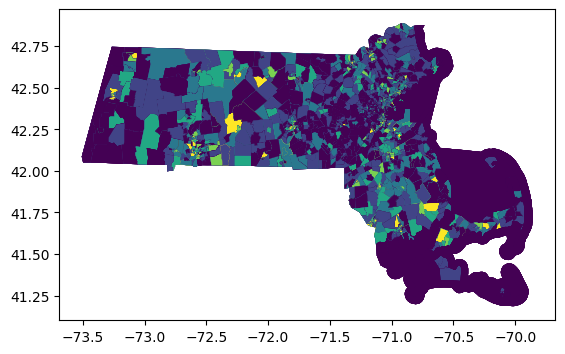

In [58]:
filtered_df.plot('deaths',vmax=5)